<a href="https://colab.research.google.com/github/prasanth5reddy/D2L/blob/master/Computer%20Vision/semantic_segmentation_and_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
w_dir = '/content/drive/My Drive/Colab/D2L.AI/'
sys.path.append(w_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Installing Libraries

In [2]:
!pip uninstall mxnet && pip install mxnet-cu100

     |████████████████████████████████| 540.1MB 37kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


Importing Libraries

In [0]:
%matplotlib inline
import d2l
from mxnet import gluon, image, nd
import os
import tarfile

Download Pascal VOC2012 Dataset

In [4]:
def download_voc_pascal(data_dir=w_dir +'data'):
    """Download the VOC2012 segmentation dataset."""
    voc_dir = os.path.join(data_dir, 'VOCdevkit/VOC2012')
    url = ('http://data.mxnet.io/data/VOCtrainval_11-May-2012.tar')
    sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
    fname = gluon.utils.download(url, data_dir, sha1_hash=sha1)
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_dir)
    return voc_dir

voc_dir = download_voc_pascal()

Read Dataset

In [0]:
def read_voc_images(root='../data/VOCdevkit/VOC2012', is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in enumerate(images):
        features[i] = image.imread('%s/JPEGImages/%s.jpg' % (root, fname))
        labels[i] = image.imread(
            '%s/SegmentationClass/%s.png' % (root, fname))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

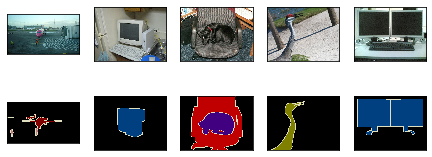

In [6]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

Color map and categories

In [0]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# Save to the d2l package.
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [0]:
def build_colormap2label():
    """Build a RGB color to label mapping for segmentation."""
    colormap2label = nd.zeros(256 ** 3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0]*256 + colormap[1])*256 + colormap[2]] = i
    return colormap2label

In [0]:
def voc_label_indices(colormap, colormap2label):
    """Map a RGB color to a label."""
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [12]:
y = voc_label_indices(train_labels[0], build_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 <NDArray 10x10 @cpu(0)>, 'aeroplane')

Data Prepocessing

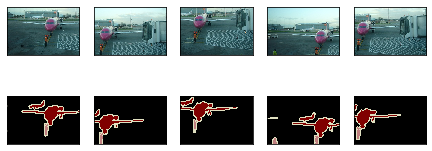

In [13]:
def voc_rand_crop(feature, label, height, width):
    """Randomly crop for both feature and label images."""
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [0]:
class VOCSegDataset(gluon.data.Dataset):
    """A customized dataset to load VOC dataset."""
    def __init__(self, is_train, crop_size, voc_dir):
        self.rgb_mean = nd.array([0.485, 0.456, 0.406])
        self.rgb_std = nd.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(root=voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = build_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose((2, 0, 1)),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

Read the Data Set

In [15]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [16]:
batch_size = 64
train_iter = gluon.data.DataLoader(voc_train, batch_size, shuffle=True,
                              last_batch='discard',
                              num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


In [0]:
def load_data_voc(batch_size, crop_size):
    """Download and load the VOC2012 semantic dataset."""
    voc_dir = d2l.download_voc_pascal()
    num_workers = d2l.get_dataloader_workers()
    train_iter = gluon.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, last_batch='discard', num_workers=num_workers)
    test_iter = gluon.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        last_batch='discard', num_workers=num_workers)
    return train_iter, test_iter